In [1]:
import warnings; 
warnings.simplefilter('ignore')

# 0. Install and Import Dependencies

In [2]:
import pandas as pd
from prophet import Prophet
from datetime import date
import san
san.ApiConfig.api_key = 'l5xaofjydbsmnivh_t3ioip3icldqopkd'
from san.extras.event_study import event_study, signals_format, hypothesis_test
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Set variables

In [44]:
symbol='flow'
TF='4h'
stime="2021-01-27"


if TF=='4h':
    format='%Y-%m-%d %H:%M:%S'   
else:
    format='%Y-%m-%d'



# 1. Read in Data and Process Dates

In [45]:
from datetime import datetime, timedelta
import ciso8601
data=pd.DataFrame()
get_df=pd.DataFrame()


start_date=ciso8601.parse_datetime(stime)
end_date=datetime.now()#- timedelta(days=120)
step= 300
numdays = (end_date- start_date).days 
print ('Get FLOW price data from: ', start_date, ' to: ', end_date)
#for h in range(0,numdays,step
h=0
end_dt=start_date
while end_dt<datetime.now():    
    start_dt= datetime.now()- timedelta(days=numdays-h)
    end_dt=start_dt+timedelta(days=step)    
    print('Reqest #:',h,' Date: ',end_dt,' get days:',(end_dt-start_dt).days)
    get_df= san.get("ohlcv/"+symbol, 
    from_date=start_dt,
    to_date=end_dt,
    interval=TF).closePriceUsd
    data=pd.concat([data,get_df] )
    h=h+step
data.columns=['Price']


Get FLOW price data from:  2021-01-27 00:00:00  to:  2022-05-11 20:28:15.582246
Reqest #: 0  Date:  2021-11-23 20:28:15.583243  get days: 300
Reqest #: 300  Date:  2022-09-19 20:28:18.015733  get days: 300


In [46]:
data.columns=['Price']
data

,Price
2021-01-27 20:00:00+00:00,6.933066
2021-01-28 00:00:00+00:00,6.136889
2021-01-28 04:00:00+00:00,7.747195
2021-01-28 08:00:00+00:00,7.259055
2021-01-28 12:00:00+00:00,7.187969
...,...
2022-05-11 00:00:00+00:00,3.887320
2022-05-11 04:00:00+00:00,3.517228
2022-05-11 08:00:00+00:00,3.911696
2022-05-11 12:00:00+00:00,3.575258


In [47]:
file_name=TF+'_Flow_price_data.csv'
data_save=data
data_save.index = pd.to_datetime(data.index)
data_save['Date']=data_save.index
data_save.reset_index(drop=True, inplace=True)
print('Save file: ',file_name)
data_save.to_csv(file_name,index=True)

Save file:  4h_Flow_price_data.csv


In [48]:
file_name=TF+'_Flow_price_data.csv'
rates=pd.read_csv(file_name)

In [49]:
rates

,Unnamed: 0,Price,Date
0,0,6.933066,2021-01-27 20:00:00+00:00
1,1,6.136889,2021-01-28 00:00:00+00:00
2,2,7.747195,2021-01-28 04:00:00+00:00
3,3,7.259055,2021-01-28 08:00:00+00:00
4,4,7.187969,2021-01-28 12:00:00+00:00
...,...,...,...
2807,2807,3.887320,2022-05-11 00:00:00+00:00
2808,2808,3.517228,2022-05-11 04:00:00+00:00
2809,2809,3.911696,2022-05-11 08:00:00+00:00
2810,2810,3.575258,2022-05-11 12:00:00+00:00


In [50]:
rates.index=pd.to_datetime(rates['Date'])

In [51]:
rates

,Unnamed: 0,Price,Date
Date,,,
2021-01-27 20:00:00+00:00,0,6.933066,2021-01-27 20:00:00+00:00
2021-01-28 00:00:00+00:00,1,6.136889,2021-01-28 00:00:00+00:00
2021-01-28 04:00:00+00:00,2,7.747195,2021-01-28 04:00:00+00:00
2021-01-28 08:00:00+00:00,3,7.259055,2021-01-28 08:00:00+00:00
2021-01-28 12:00:00+00:00,4,7.187969,2021-01-28 12:00:00+00:00
...,...,...,...
2022-05-11 00:00:00+00:00,2807,3.887320,2022-05-11 00:00:00+00:00
2022-05-11 04:00:00+00:00,2808,3.517228,2022-05-11 04:00:00+00:00
2022-05-11 08:00:00+00:00,2809,3.911696,2022-05-11 08:00:00+00:00


In [52]:
#import io
#df = pd.read_table(io.StringIO(rates), delim_whitespace=True)
df=rates
df.index = pd.to_datetime(df.index)
#df.index = pd.to_datetime(df.index)
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df.index=pd.to_datetime(df.index).strftime(format)
df['ds'] = pd.to_datetime(df.index)
#rates2.index=pd.to_datetime(rates2.index).strftime('%Y-%m-%d')
#df['ds'] = pd.DatetimeIndex(df['Year']+'-'+df['Month']+'-'+df['Day'])

In [53]:
df_prohet=pd.DataFrame()
df_no_index = df.reset_index(drop=True)
df_prohet['y']=df_no_index['Price']
df_prohet['ds']=df_no_index['ds']


In [54]:
df_prohet.head()

,y,ds
0,6.933066,2021-01-27 20:00:00
1,6.136889,2021-01-28 00:00:00
2,7.747195,2021-01-28 04:00:00
3,7.259055,2021-01-28 08:00:00
4,7.187969,2021-01-28 12:00:00


In [55]:
df_prohet.tail()

,y,ds
2807,3.887320,2022-05-11 00:00:00
2808,3.517228,2022-05-11 04:00:00
2809,3.911696,2022-05-11 08:00:00
2810,3.575258,2022-05-11 12:00:00
2811,3.386978,2022-05-11 16:00:00


# Find best Params? (SKEEP IF DO NOT NEED)

In [85]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation



param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [ ]:
all_params

In [86]:

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params,seasonality_mode='multiplicative').fit(df_prohet)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Making 5 forecasts with cutoffs between 2022-02-10 16:00:00 and 2022-04-11 16:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021C3C41D8C8>
INFO:prophet:Making 5 forecasts with cutoffs between 2022-02-10 16:00:00 and 2022-04-11 16:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021C3C4E1D48>


In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


# 2. Train Model

In [56]:
m = Prophet(interval_width=0.95, 
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.5,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=0.1
    )
model = m.fit(df_prohet)

# 3. Forecast Away

In [57]:
future = m.make_future_dataframe(periods=30,freq=TF)
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2836,2022-05-16 00:00:00,8.636821,0.989504,6.781254,7.622649,9.383128,-0.000935,-0.000935,-0.000935,-0.544628,...,-0.000967,-0.000967,-0.000967,-0.542726,-0.542726,-0.542726,0.0,0.0,0.0,3.932964
2837,2022-05-16 04:00:00,8.645528,1.132221,6.667810,7.541375,9.439362,0.001801,0.001801,0.001801,-0.542873,...,0.001201,0.001201,0.001201,-0.545875,-0.545875,-0.545875,0.0,0.0,0.0,3.952104
2838,2022-05-16 08:00:00,8.654236,1.124181,6.877807,7.460952,9.521706,-0.001016,-0.001016,-0.001016,-0.546827,...,0.003210,0.003210,0.003210,-0.549021,-0.549021,-0.549021,0.0,0.0,0.0,3.921862
2839,2022-05-16 12:00:00,8.662944,0.908505,6.656241,7.369240,9.565920,-0.000140,-0.000140,-0.000140,-0.547433,...,0.004868,0.004868,0.004868,-0.552161,-0.552161,-0.552161,0.0,0.0,0.0,3.920560
2840,2022-05-16 16:00:00,8.671651,0.881965,6.596657,7.278041,9.628974,-0.000569,-0.000569,-0.000569,-0.549809,...,0.006054,0.006054,0.006054,-0.555294,-0.555294,-0.555294,0.0,0.0,0.0,3.903896


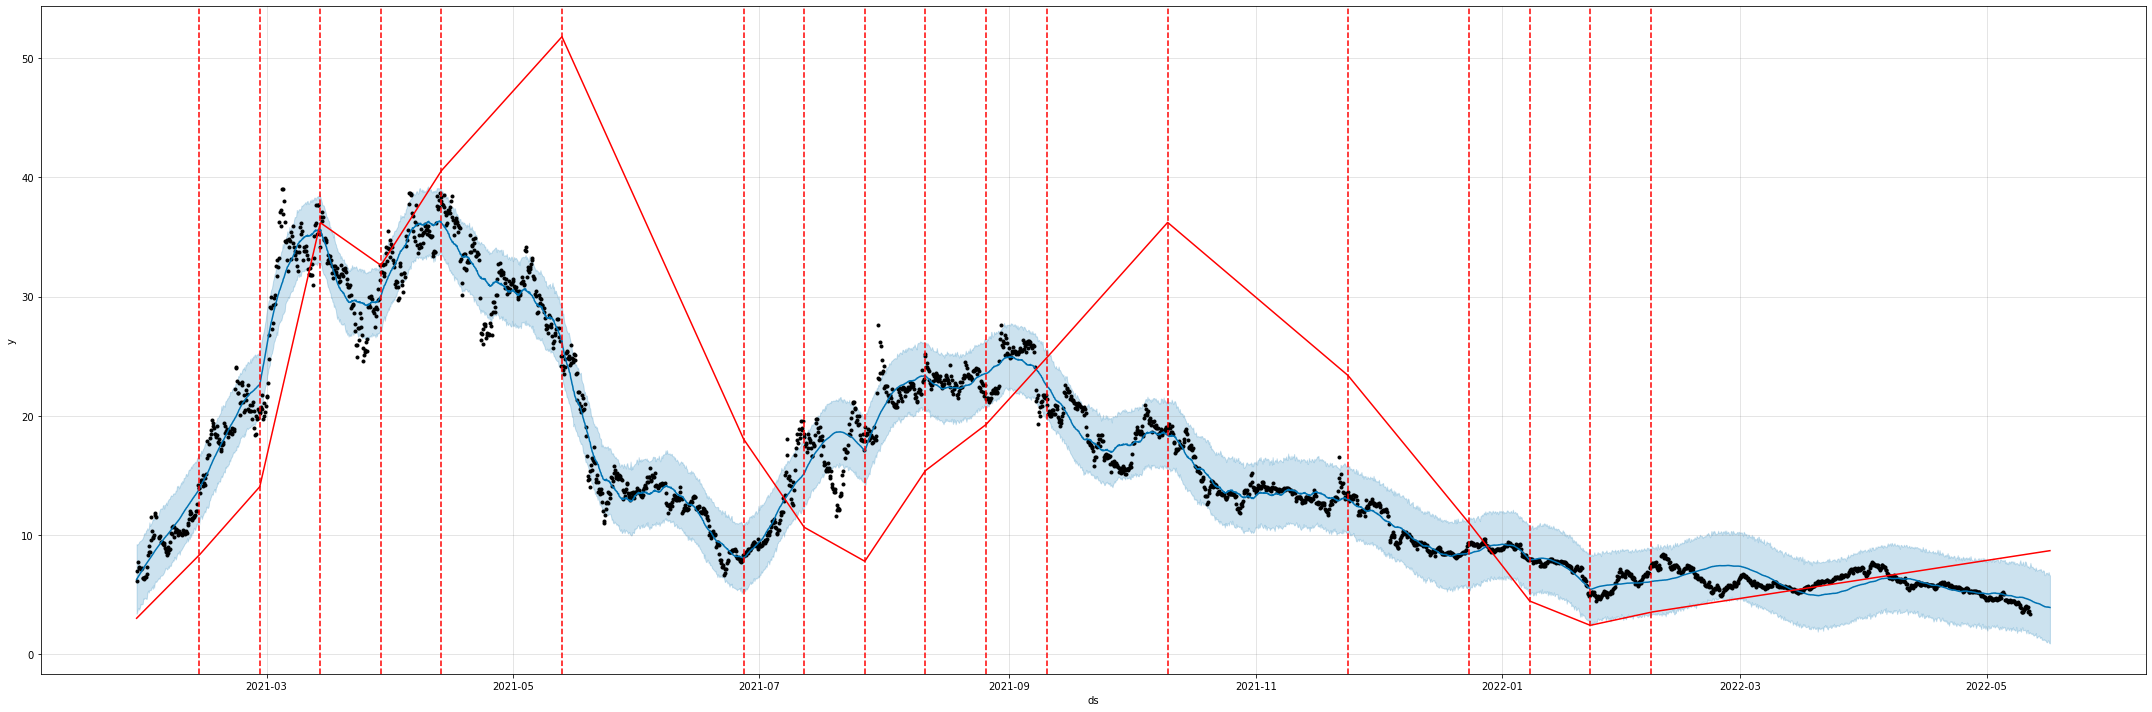

In [58]:
from prophet.plot import add_changepoints_to_plot
plot1 = m.plot(forecast,figsize = (30, 10))
a = add_changepoints_to_plot(plot1.gca(), m, forecast)


In [59]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2836,2022-05-16 00:00:00,8.636821,0.989504,6.781254,7.622649,9.383128,-0.000935,-0.000935,-0.000935,-0.544628,...,-0.000967,-0.000967,-0.000967,-0.542726,-0.542726,-0.542726,0.0,0.0,0.0,3.932964
2837,2022-05-16 04:00:00,8.645528,1.132221,6.667810,7.541375,9.439362,0.001801,0.001801,0.001801,-0.542873,...,0.001201,0.001201,0.001201,-0.545875,-0.545875,-0.545875,0.0,0.0,0.0,3.952104
2838,2022-05-16 08:00:00,8.654236,1.124181,6.877807,7.460952,9.521706,-0.001016,-0.001016,-0.001016,-0.546827,...,0.003210,0.003210,0.003210,-0.549021,-0.549021,-0.549021,0.0,0.0,0.0,3.921862
2839,2022-05-16 12:00:00,8.662944,0.908505,6.656241,7.369240,9.565920,-0.000140,-0.000140,-0.000140,-0.547433,...,0.004868,0.004868,0.004868,-0.552161,-0.552161,-0.552161,0.0,0.0,0.0,3.920560
2840,2022-05-16 16:00:00,8.671651,0.881965,6.596657,7.278041,9.628974,-0.000569,-0.000569,-0.000569,-0.549809,...,0.006054,0.006054,0.006054,-0.555294,-0.555294,-0.555294,0.0,0.0,0.0,3.903896


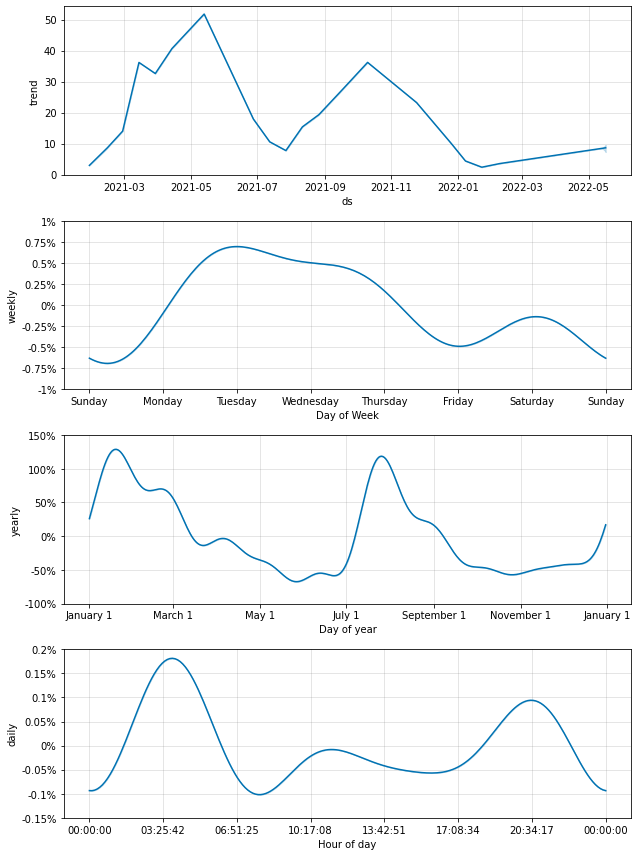

In [60]:
plt2 = m.plot_components(forecast)

In [20]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
375,2022-06-06,3.079353,0.124328,8.156421,0.205778,5.640308,0.277244,0.277244,0.277244,0.387701,...,-0.011689,-0.011689,-0.011689,0.122146,0.122146,0.122146,0.0,0.0,0.0,4.273221
376,2022-06-07,3.057619,0.001583,7.947440,0.031715,5.762526,0.277244,0.277244,0.277244,0.304166,...,-0.036336,-0.036336,-0.036336,0.063258,0.063258,0.063258,0.0,0.0,0.0,3.987643
377,2022-06-08,3.035886,-0.483887,7.863492,-0.130040,5.905610,0.277244,0.277244,0.277244,0.280654,...,0.001404,0.001404,0.001404,0.002006,0.002006,0.002006,0.0,0.0,0.0,3.887921
378,2022-06-09,3.014152,-0.768437,7.788933,-0.308498,6.014084,0.277244,0.277244,0.277244,0.209345,...,-0.007136,-0.007136,-0.007136,-0.060764,-0.060764,-0.060764,0.0,0.0,0.0,3.645149
379,2022-06-10,2.992419,-0.690275,7.681004,-0.476551,6.177583,0.277244,0.277244,0.277244,0.163189,...,0.010143,0.010143,0.010143,-0.124199,-0.124199,-0.124199,0.0,0.0,0.0,3.480749


In [61]:
forecast2 = forecast.set_index ('ds')


In [23]:
#%pip install mplcursors

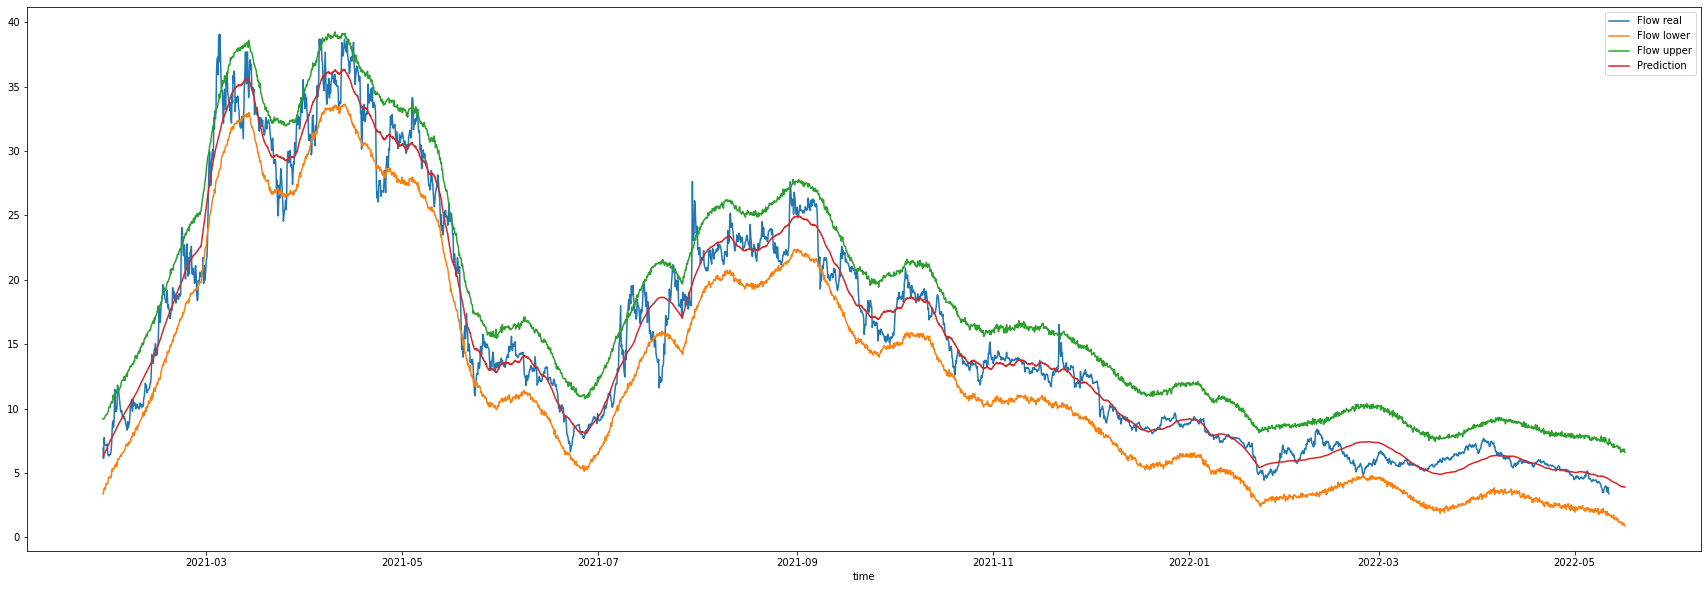

In [62]:
df_plt=df.set_index ('ds')
y=df_plt['2021-01-01': ]['Price']
yhat=forecast2['2021-01-01': ]['yhat']
yhat_upper=forecast2['2021-01-01': ]['yhat_upper']
yhat_lowwer=forecast2['2021-01-01': ]['yhat_lower']
plt.figure(figsize=(30, 10))
plt.plot(y['2021-01-01':], label='Flow real')
plt.plot(yhat_lowwer['2021-01-01':], label='Flow lower')
plt.plot(yhat_upper['2021-01-01':], label='Flow upper')
plt.plot(yhat['2021-01-01':], label='Prediction')

plt.xlabel('time', size=10)
plt.legend(fontsize=10)

plt.show()

In [25]:
#%pip install plotly 

In [83]:
# import plotly packages 
import plotly.graph_objects as go
import plotly.express as px

x=forecast2['2021-01-01': ].index.strftime(format)
real_price=go.Scatter(x=x, 
        y=y['2021-01-01':], 
        name='Real Flow',
        line = dict(color = 'firebrick', width = 1),
        text = x,
        #mode = 'markers',
        marker=dict(color='#ffcdd2')
        #marker = dict(size = 1,color = 'firebrick',opacity = 0.5),
        #hoverinfo = 'text+y+name'
        )
prediction_price=go.Scatter(x=x, y=yhat['2021-01-01':], name='Predicted Flow',\
        line = dict(color = 'blue', width = 1),
        text = x,
        #mode = 'markers',
        #marker = dict(size = 1,color = 'blue',opacity = 0.5),
        hoverinfo = 'text+y+name')
upper=go.Scatter(x=x, y=yhat_upper['2021-01-01':], name='Upper Bound',\
        line = dict(color = 'green', width = 1),
        text = x,
        #mode = 'markers',
        #marker = dict(size = 1,color = 'green',opacity = 0.5),
        hoverinfo = 'text+y+name')
lower=go.Scatter(x=x, y=yhat_lowwer['2021-01-01':], name='Lower Bound',\
        line = dict(color = 'red', width = 1),
        text = x,
        #mode = 'markers',
        #marker = dict(size = 1,color = 'red',opacity = 0.5),
        hoverinfo = 'text+y+name')        
fig=go.Figure(data=[real_price,prediction_price,upper,lower])

In [84]:
# step 2 : Setting the update_layout function   
fig.update_layout(title='Predicted Flow',
                   xaxis_title='Date',
                   yaxis_title='Predicted Flow',
                   font=dict(family='Courier New, monospace'),
                   legend_orientation="v",                   
                   hovermode='closest'
                   )